In [1]:
!pip install category-encoders -U -q
!pip install scikit-learn -U -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 75.8 MB/s eta 0:00:00:00:0100:01


In [2]:
# based on the post here: https://www.kaggle.com/c/petfinder-pawpularity-score/discussion/275094

import sys

import albumentations
import pandas as pd
import cv2
import numpy as np
import timm
import torch.nn as nn
from sklearn import metrics
import torch
from tqdm import tqdm
import math
import pickle
from matplotlib import pyplot as plt
import pickle
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold

from scipy import stats

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
import torch
torch.cuda.is_available()

True

In [11]:
import os
from tqdm import tqdm
import cv2

root_path = "."

# data_path = '/kaggle/input/zindi-rootvolume-datainput1/data/train'
# image_dict = {}
# for path_ in tqdm(os.listdir(data_path)):
#     for fn in os.listdir(f'{data_path}/{path_}'):
#         image = cv2.imread(f"{data_path}/{path_}/{fn}")
#         image_dict[fn.split('.')[0]] = image

# ===============================================

image_dict = {}

for dtype in ['train', 'test']:
    data_path = f'{root_path}/data/{dtype}'
    
    for path_ in tqdm(os.listdir(data_path)):
        for fn in os.listdir(f'{data_path}/{path_}'):
            image = cv2.imread(f"{data_path}/{path_}/{fn}")
            image_dict[fn.split('.')[0]] = image

100%|██████████| 62/62 [00:03<00:00, 18.41it/s]


In [12]:
import pickle

yolo_masks = pickle.load(open(f"{root_path}/yolo_mask_full.pkl", "rb"))
yolo_masks.keys()

dict_keys(['full'])

In [13]:
# new_yolo_mask = {}
# new_yolo_mask['full'] = yolo_masks['full']
# pickle.dump(new_yolo_mask, open("./yolo_mask_full.pkl", "wb"))

In [14]:
import os
import shutil

# Fungsi untuk membersihkan cache
def clear_huggingface_cache():
    cache_dir = os.path.join(os.path.expanduser("~"), ".cache", "huggingface")
    if os.path.exists(cache_dir):
        shutil.rmtree(cache_dir)
        # print(f"Cache di {cache_dir} berhasil dihapus.")
    else:
        print(f"Tidak ada cache di {cache_dir}.")

In [15]:
#from tifffile import imread, TiffFile

train_image_path = f'{root_path}/data/train'
test_image_path = f'{root_path}/data/test'

In [16]:

import pickle

if torch.cuda.is_available() == False:
    from sklearn.svm import SVR
else:
    from sklearn.svm import SVR
    # import cuml
    # from cuml.svm import SVR
    # print('RAPIDS version',cuml.__version__,'\n')

df_train_raw = pd.read_csv(f'{root_path}/Train.csv',)
df_test_raw = pd.read_csv(f'{root_path}/Test.csv',)

print('Train shape:', df_train_raw.shape )
df_train_raw.head()

RAPIDS version 24.12.00 

Train shape: (386, 9)


,ID,FolderName,PlantNumber,Side,Start,End,RootVolume,Genotype,Stage
0,ID_826322_Lbmaya,A6dzrkjqvl,3,L,33,42,0.9,IITA-TMS-IBA000070,Early
1,ID_718181_Bslpwx,Ypktwvqjbn,7,L,33,41,1.5,IBA154810,Early
2,ID_465762_L1n61d,Ox18ob0syv,4,R,21,28,2.7,IBA980581,Early
3,ID_626872_Pbmx2e,Hqcekwpxgu,2,R,30,39,2.6,IITA-TMS-IBA000070,Early
4,ID_518846_Opko8c,Ummqfuetoc,1,R,17,26,2.7,IBA980581,Early


In [17]:
df_test_raw['RootVolume'] = 0.0

In [18]:
side_pair = {1 : 7,
             2 : 6,
             3 : 5,
             4 : 4,
             5 : 3,
             6 : 2,
             7 : 1}

def set_pair_idx(df, with_label_check = False):    
    c = 1
    
    pair_index = np.ones((len(df)), dtype = np.int32) * -1
    
    for ridx, row in tqdm(df.iterrows(), total = len(df)):
        if pair_index[ridx] > 0:
            continue
        
        fn = row['FolderName']
        side = row['Side']
        pn = row['PlantNumber']
        # rv = row['RootVolume']
    
        if side == 'L':
            oppside = 'R'
        else:
            oppside = 'L'
    
        pair_pn = side_pair[pn]
    
        pair_df = df[(df['FolderName'] == fn) & (df['Side'] == oppside) & (df['PlantNumber'] == pair_pn)]
        
        if len(pair_df) <= 0:
            continue
    
        pair_index[ridx] = c
        pair_index[pair_df.index[0]] = c
        c += 1
    
    df['PairIdx'] = pair_index

    return df

df_train_raw = set_pair_idx(df_train_raw)
df_test_raw = set_pair_idx(df_test_raw)

100%|██████████| 130/130 [00:00<00:00, 1503.30it/s]


In [19]:
# mask_resume = {'full': {}, 'early': {}, 'late': {}}
# mask_maxcount = {'full': 0, 'early': 0, 'late': 0}

# for stage in mask_resume.keys():
#     print("======", stage)

#     for df in [df_train_raw, df_test]:

#         for fn_side in (df['FolderName'] + '_' + df['Side']).unique():
            
#             # ks = [k for k in yolo_masks[stage].keys() if k.startswith(fn_side)]

#             # assert a==kajsdhsa
            
#             im = np.zeros((32 * 80, 640))
            
#             # for k_ in ks:
            
#             for i in range(80):
#                 k_ = f"{fn_side}_{('000' + str(i))[-3:]}"
#                 if k_ in yolo_masks[stage]:
#                     im[i*32:(i+1)*32] = np.sum(yolo_masks[stage][k_], axis = 0)
        
#             mask_resume[stage][fn_side] = im
#             mask_maxcount[stage] = max(mask_maxcount[stage], im.max())
        
#         plt.imshow(im / mask_maxcount[stage])
#         plt.axis('off')
#         plt.show()

# print("max_mask_count", mask_maxcount)

In [20]:
Genotype_dict = {k:v for v, k in enumerate(df_train_raw['Genotype'].unique())}
Stage_dict = {k:v for v, k in enumerate(df_train_raw['Stage'].unique())}

df_train_raw['Genotype_cat'] = df_train_raw['Genotype'].map(Genotype_dict)
df_train_raw['Stage_cat'] = df_train_raw['Stage'].map(Stage_dict)
df_train_raw['stack_count'] = df_train_raw['End'] - df_train_raw['Start']
df_train_raw

,ID,FolderName,PlantNumber,Side,Start,End,RootVolume,Genotype,Stage,PairIdx,Genotype_cat,Stage_cat,stack_count
0,ID_826322_Lbmaya,A6dzrkjqvl,3,L,33,42,0.9,IITA-TMS-IBA000070,Early,-1,0,0,9
1,ID_718181_Bslpwx,Ypktwvqjbn,7,L,33,41,1.5,IBA154810,Early,-1,1,0,8
2,ID_465762_L1n61d,Ox18ob0syv,4,R,21,28,2.7,IBA980581,Early,1,2,0,7
3,ID_626872_Pbmx2e,Hqcekwpxgu,2,R,30,39,2.6,IITA-TMS-IBA000070,Early,-1,0,0,9
4,ID_518846_Opko8c,Ummqfuetoc,1,R,17,26,2.7,IBA980581,Early,2,2,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,ID_592215_Hfzzen,Ntqusw7xpb,4,L,19,31,2.2,TMEB419,Early,12,3,0,12
382,ID_995502_L5bkz9,Izbgyxre0g,4,R,22,33,1.3,IBA154810,Early,126,1,0,11
383,ID_490708_Isn2o5,Efaiye0hmy,1,R,20,30,4.8,IBA980581,Early,-1,2,0,10
384,ID_899134_Gyrlfg,Rzyf8hal4j,1,R,38,47,1.3,IBA154810,Early,29,1,0,9


In [21]:
df_test_raw

,ID,FolderName,PlantNumber,Side,Start,End,Genotype,Stage,RootVolume,PairIdx
0,ID_208667_Hnkl8q,L5l1h3kekg,7,L,38,50,IITA-TMS-IBA000070,Early,0.0,1
1,ID_285249_Jnjvav,Wgutyon8uu,6,R,23,37,TMEB419,Early,0.0,2
2,ID_697947_Yec6bd,Mylwjeq6tq,3,R,19,42,IBA980581,Early,0.0,-1
3,ID_534638_X3j91f,Pfp24vx905,2,R,27,34,TMEB419,Early,0.0,-1
4,ID_929298_Xvymuz,Mrw7chmalv,4,R,30,43,IBA154810,Early,0.0,3
...,...,...,...,...,...,...,...,...,...,...
125,ID_652025_Ecubfg,L8w7zu7wek,4,L,33,51,IITA-TMS-IBA000070,Early,0.0,20
126,ID_456856_Iucagp,Klhqlr0ako,2,L,38,47,TMEB693,Early,0.0,-1
127,ID_163551_Alfdb5,Vlqr6qhbqk,3,L,48,55,IBA154810,Early,0.0,36
128,ID_947929_Qsuqln,Pfp24vx905,5,R,27,34,TMEB419,Early,0.0,-1


In [22]:
df_test_raw['Genotype_cat'] = df_test_raw['Genotype'].map(Genotype_dict)
df_test_raw['Stage_cat'] = df_test_raw['Stage'].map(Stage_dict)
df_test_raw['stack_count'] = df_test_raw['End'] - df_test_raw['Start']
df_test_raw

,ID,FolderName,PlantNumber,Side,Start,End,Genotype,Stage,RootVolume,PairIdx,Genotype_cat,Stage_cat,stack_count
0,ID_208667_Hnkl8q,L5l1h3kekg,7,L,38,50,IITA-TMS-IBA000070,Early,0.0,1,0,0,12
1,ID_285249_Jnjvav,Wgutyon8uu,6,R,23,37,TMEB419,Early,0.0,2,3,0,14
2,ID_697947_Yec6bd,Mylwjeq6tq,3,R,19,42,IBA980581,Early,0.0,-1,2,0,23
3,ID_534638_X3j91f,Pfp24vx905,2,R,27,34,TMEB419,Early,0.0,-1,3,0,7
4,ID_929298_Xvymuz,Mrw7chmalv,4,R,30,43,IBA154810,Early,0.0,3,1,0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,ID_652025_Ecubfg,L8w7zu7wek,4,L,33,51,IITA-TMS-IBA000070,Early,0.0,20,0,0,18
126,ID_456856_Iucagp,Klhqlr0ako,2,L,38,47,TMEB693,Early,0.0,-1,4,0,9
127,ID_163551_Alfdb5,Vlqr6qhbqk,3,L,48,55,IBA154810,Early,0.0,36,1,0,7
128,ID_947929_Qsuqln,Pfp24vx905,5,R,27,34,TMEB419,Early,0.0,-1,3,0,7


# DF_Train generator -----

In [23]:
def generate_train_df( df_raw, 
                       left_offset_list = [0], 
                       right_offset_list = [0],
                       margin_mode = 2,
                       is_train_data = True ):

    global PLANT_MARGIN, L_PLANT_MARGIN

    train_df_dict = {
                    'ID' : [],
                    'FolderName' : [],
                    'PlantNumber' : [],
                    'Side' : [],
                    'Start' : [],
                    'End' : [],
                    'LeftSlide' : [],
                    'RightSlide' : [],
                    'Genotype' : [],
                    'Stage' : [],
                    'PairIdx' : [],
                    'Genotype_cat' : [],
                    'Stage_cat' : [],
                    'stack_count' : [],
                    'RootVolume' : []
                    }

    if margin_mode == 3:
        right_offset_list = [0]
    
    for ridx, row in df_raw.iterrows():

        start = 1
        end = 80
        
        # for sidx in range(row['Start'], row['End'], step):
        #     start = min(sidx, 81 - stack_cnt)
        
        # base_left = PLANT_MARGIN[row['PlantNumber']-1][0]
        # base_right = PLANT_MARGIN[row['PlantNumber']-1][1]
        
        for left_offset in left_offset_list:
            for right_offset in right_offset_list:
                
                train_df_dict[ 'LeftSlide' ].append(left_offset)
                if margin_mode == 3:
                    train_df_dict[ 'RightSlide' ].append(left_offset)
                else:
                    train_df_dict[ 'RightSlide' ].append(right_offset)

                train_df_dict[ 'ID' ].append(row['ID'])
                train_df_dict[ 'FolderName' ].append(row['FolderName'])
                train_df_dict[ 'PlantNumber' ].append(row['PlantNumber'])
                train_df_dict[ 'Side' ].append(row['Side'])
                train_df_dict[ 'Start' ].append(start)
                train_df_dict[ 'End' ].append(end)
                train_df_dict[ 'Genotype' ].append(row['Genotype'])
                train_df_dict[ 'Stage' ].append(row['Stage'])
                train_df_dict[ 'PairIdx' ].append(row['PairIdx'])
                train_df_dict[ 'Genotype_cat' ].append(row['Genotype_cat'])
                train_df_dict[ 'Stage_cat' ].append(row['Stage_cat'])
                train_df_dict[ 'stack_count' ].append(row['stack_count'])
                train_df_dict[ 'RootVolume' ].append(row['RootVolume'])

    df = pd.DataFrame(train_df_dict)

    if is_train_data == True:
        target_value = df['RootVolume'].values
        divider = 30
        tgtmin = target_value.min()
        tgtmax = target_value.max()
        
        delta = (tgtmax-tgtmin) / divider
        
        target_digit = np.digitize(target_value, [tgtmin + (v * delta) for v in range(divider + 1)])
        # target_digit = np.digitize(target_value, np.quantile(target_value, np.arange(divider)/divider))
        
        # target_digit[target_digit > 15] = 16
        # display(np.unique(target_digit,return_counts = True))

        df['target_digit'] = target_digit

        df_return = df.copy()
        df_return['flip'] = 0
        df_return['rotate'] = 0
        
        # for flip in [0,1]:
        #     for rotate in [0,2]:
        #         if flip == 0 and rotate == 0:
        #             continue

        #         df_temp = df.copy()
        #         df_temp['flip'] = flip
        #         df_temp['rotate'] = rotate

        #         df_return = pd.concat([df_return, df_temp])

    else:
        df['target_digit'] = df['RootVolume'].values

        df_return = df
    
    return df_return

In [24]:
def set_seed(seed=42):

    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    os.environ['PYTHONHASHSEED'] = str(seed)


In [25]:
from urllib.request import urlopen
from PIL import Image
import timm
import torchvision.transforms as transforms
from itertools import combinations, product, permutations
from sklearn.metrics import mean_squared_error, root_mean_squared_error
import pickle
from torch.utils.data import Dataset, DataLoader
from catboost import CatBoostRegressor, Pool
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import os
import gc
import time
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import numpy as np

In [26]:
def resize_numpy(image, new_shape):
    old_h, old_w = image.shape
    new_h, new_w = new_shape
    
    # Buat grid koordinat dalam skala baru
    y = np.linspace(0, old_h - 1, new_h)
    x = np.linspace(0, old_w - 1, new_w)
    
    # Konversi ke indeks integer dan bobot interpolasi
    x0 = np.floor(x).astype(int)
    x1 = np.clip(x0 + 1, 0, old_w - 1)
    y0 = np.floor(y).astype(int)
    y1 = np.clip(y0 + 1, 0, old_h - 1)

    # Buat meshgrid untuk semua koordinat target
    x_grid, y_grid = np.meshgrid(x, y)
    x0_grid, y0_grid = np.meshgrid(x0, y0)
    x1_grid, y1_grid = np.meshgrid(x1, y1)

    # Ambil nilai piksel di empat titik terdekat
    Ia = image[y0_grid, x0_grid]
    Ib = image[y1_grid, x0_grid]
    Ic = image[y0_grid, x1_grid]
    Id = image[y1_grid, x1_grid]

    # Hitung bobot interpolasi
    wa = (x1_grid - x_grid) * (y1_grid - y_grid)
    wb = (x1_grid - x_grid) * (y_grid - y0_grid)
    wc = (x_grid - x0_grid) * (y1_grid - y_grid)
    wd = (x_grid - x0_grid) * (y_grid - y0_grid)

    # Interpolasi bilinear
    new_image = wa * Ia + wb * Ib + wc * Ic + wd * Id

    return new_image

array_awal = np.random.rand(340, 480, 3)

# Dimensi target
target_height, target_width, target_channels = 560, 790, 3

# Hitung faktor skala
scale_height = target_height / array_awal.shape[0]
scale_width = target_width / array_awal.shape[1]

# Buat grid koordinat untuk array target
x = np.arange(target_width)
y = np.arange(target_height)

# Hitung koordinat sumber (nearest-neighbor)
x_source = np.floor(x / scale_width).astype(int)
y_source = np.floor(y / scale_height).astype(int)

# Clip koordinat sumber agar tidak melebihi batas array asli
x_source = np.clip(x_source, 0, array_awal.shape[1] - 1)
y_source = np.clip(y_source, 0, array_awal.shape[0] - 1)

# Resize array menggunakan nearest-neighbor
array_resized = array_awal[y_source[:, None], x_source]

In [27]:
import cv2
from sklearn.preprocessing import StandardScaler
import os

# def padding_image(image, w, h):
#     pad_width = [
#                     (0, h - image.shape[0]),
#                     (0, w - image.shape[1]),
#                     (0, 0)
#                 ]

#     return np.pad( image, pad_width, mode='constant', constant_values = 0 )

def padding_image(image, w, h):
    # Dimensi saat ini
    current_h, current_w = image.shape[:2]
    
    # Jika dimensi array lebih besar dari yang diinginkan, potong array
    if current_h > h:
        image = image[:h, :]
    if current_w > w:
        image = image[:, :w]
    
    # Jika dimensi array lebih kecil dari yang diinginkan, tambahkan padding
    pad_height = max(0, h - image.shape[0])
    pad_width = max(0, w - image.shape[1])
    
    pad_dims = [
        (0, pad_height),
        (0, pad_width),
        (0, 0)  # Untuk channel (jika ada)
    ]
    
    return np.pad(image, pad_dims, mode='constant', constant_values=0)

def gen_image_v1( img_path, 
                  fn, 
                  plant_number, 
                  side, 
                  start, 
                  end, 
                  cropped = False, 
                  segment_width = 200 ):

    global PLANT_MARGIN, L_PLANT_MARGIN, image_dict
    
    mean_img = None
    
    for counter in range(start, end+1):
        
        sc = f'0000{counter}'[-3:]
        k = f'{fn}_{side}_{sc}'
        # image = cv2.imread(f"{img_path}/{fn}/{fn}_{side}_{sc}.png")
        if k in image_dict:
            image = image_dict[k]

        if side == 'L':
            start_idx = int(L_PLANT_MARGIN[plant_number-1][0] * image.shape[1])
            end_idx = int(L_PLANT_MARGIN[plant_number-1][1] * image.shape[1])
        else:
            start_idx = int(PLANT_MARGIN[plant_number-1][0] * image.shape[1])
            end_idx = int(PLANT_MARGIN[plant_number-1][1] * image.shape[1])
        
        image = image[:,start_idx:end_idx,:]
    
        if mean_img is None:
            mean_img = image
        else:
            mean_img += image
    
    mean_img = ((mean_img - mean_img.min()) / mean_img.ptp())

    if cropped:
        return padding_image(mean_img, segment_width, 14)
    else:
        return mean_img

def sub_gen_image_v2( img_path, 
                  fn, 
                  plant_number, 
                  side,
                  left_slide,
                  right_slide,
                  start, 
                  end, 
                  min_stack = 5,
                  max_stack = 20,
                  cropped = False,
                  segment_width = 200,
                  mask_stage = 'full',
                  flip = 0,
                  rotate = 0):
    
    global PLANT_MARGIN, L_PLANT_MARGIN
    global IMAGE_STACK_MODE
    
    stack_img = None

    stack_n = 0
    mask = None
    
    if side == 'L':
        mask_start_idx = max(0, int((L_PLANT_MARGIN[plant_number-1][0]) * 640) + left_slide)
        mask_end_idx = max(mask_start_idx+10, int((L_PLANT_MARGIN[plant_number-1][1]) * 640) + right_slide)
    else:
        mask_start_idx = max(0, int((PLANT_MARGIN[plant_number-1][0]) * 640) + left_slide)
        mask_end_idx = max(mask_start_idx+10, int((PLANT_MARGIN[plant_number-1][1]) * 640) + right_slide)
        
    if mask_end_idx > 640:
        mask_start_idx -= (640 - mask_end_idx)
        mask_end_idx = 640


    # mask_start_idx = int(left_pos * 640)
    # mask_end_idx = int(right_pos * 640)

    for counter in range(start + 1, 82): #end+1):
        
        sc = ('0000' + str(counter))[-3:]
        # fn = f"{img_path}/{fn}/{fn}_{side}_{sc}.png"
        # if not os.path.exists(fn):
        #     break

        # image = cv2.imread()
        im_key = f'{fn}_{side}_{sc}'
        
        if not im_key in image_dict:
            #image = image_dict[im_key]
            continue
        
        image = image_dict[im_key]

        if side == 'L':
            start_idx = max(0, int((L_PLANT_MARGIN[plant_number-1][0]) * image.shape[1]) + left_slide)
            end_idx = max(start_idx+10, int((L_PLANT_MARGIN[plant_number-1][1]) * image.shape[1]) + right_slide)
        else:
            start_idx = max(0, int((PLANT_MARGIN[plant_number-1][0]) * image.shape[1]) + left_slide)
            end_idx = max(start_idx+10, int((PLANT_MARGIN[plant_number-1][1]) * image.shape[1]) + right_slide)
            
        if end_idx > image.shape[1]:
            start_idx -= (end_idx - image.shape[1])
            end_idx = image.shape[1]
    
        # start_idx = int(left_pos * image.shape[1])
        # end_idx = int(right_pos * image.shape[1])

        image = image[:,start_idx:end_idx,:]

# # [:,:,mask_start_idx:mask_end_idx]
        
        if im_key in yolo_masks['full']:
            mask_image = np.sum(yolo_masks['full'][im_key][:,:,mask_start_idx:mask_end_idx], axis = 0)
            # print("A", im_key, mask_start_idx, mask_end_idx, mask_image.shape)
            if IMAGE_STACK_MODE in [5,6]:
                mask_image[:,:] = np.max(mask_image, axis = 0)
        else:
            mask_image = np.zeros((32, mask_end_idx-mask_start_idx))
            # print("B", im_key, mask_start_idx, mask_end_idx, mask_image.shape)

        if stack_img is None:
            stack_img = image
            mask = mask_image
        else:
            stack_img = np.concatenate((stack_img, image), axis = 0)
            mask = np.concatenate((mask, mask_image), axis = 0)

        stack_n += 1
        if stack_n >= max_stack:
            end = counter
            break

    # mask_start_idx = int(PLANT_MARGIN[plant_number-1][0] * 640)
    # mask_end_idx = int(PLANT_MARGIN[plant_number-1][1] * 640)

    # fn_side = f'{fn}_{side}'
    
    # if fn_side in mask_resume[mask_stage]:
    #     mask = mask_resume[mask_stage][fn_side][:,mask_start_idx:mask_end_idx] # / mask_maxcount[stage]
    #     if mask.ptp() <= 0.0:
    #         mask = mask_resume['full'][fn_side][:,mask_start_idx:mask_end_idx] # / mask_maxcount[stage]
    # else:
    #     mask = mask_resume['full'][fn_side][:,mask_start_idx:mask_end_idx] # / mask_maxcount[stage]

    # mask[mask > 0] = 1
    # # mask /= mask_maxcount[stage]
    # # mask = (mask - mask.min()) / mask.ptp()
    
    mask = resize_numpy(mask, (stack_img.shape[0], stack_img.shape[1]))
    rgb_mask = np.stack([mask] * 3, axis=-1) * 255.0

    if flip == 1:
        stack_img = np.flip(stack_img, axis=1)
        rgb_mask = np.flip(rgb_mask, axis=1)

    if rotate > 0:
        stack_img = np.rot90(stack_img, k = rotate, axes=(0, 1))
        rgb_mask = np.rot90(rgb_mask, k = rotate, axes=(0, 1))
        

    # if side == 'L':
    #     stack_img = np.flip(stack_img, axis=1)
    #     rgb_mask = np.flip(rgb_mask, axis=1)

            
    # if self.df.iloc[idx]['rotate'] > 0:
    #     img = np.rot90(img, k=self.df.iloc[idx]['rotate'], axes=(0, 1))

    # stack_img = np.concatenate((stack_img, rgb_mask), axis=1)
    
    if IMAGE_STACK_MODE == 1:
        stack_img = np.concatenate((stack_img, rgb_mask), axis=1)
    elif IMAGE_STACK_MODE == 2:
        stack_img = np.maximum(stack_img, rgb_mask)
    elif IMAGE_STACK_MODE == 3:
        stack_img = stack_img + rgb_mask
    elif IMAGE_STACK_MODE == 4:
        stack_img[rgb_mask > 0] = 0
    elif IMAGE_STACK_MODE == 5:
        stack_img[rgb_mask > 0] = 255
    elif IMAGE_STACK_MODE == 6:
        stack_img = np.mean([stack_img, rgb_mask], axis = 0)
    elif IMAGE_STACK_MODE == 7:
        pass
    
    if cropped:
        return padding_image(stack_img / 255.0, segment_width, 14 * max_stack)
    else:
        return stack_img / 255.0

def gen_image_v2( img_path, 
                  fn, 
                  plant_number, 
                  side, 
                  left_slide,
                  right_slide,
                  start, 
                  end, 
                  min_stack = 5,
                  max_stack = 20,
                  cropped = False,
                  segment_width = 200,
                  mask_stage = 'full',
                  flip = 0,
                  rotate = 0):

    global side_pair

    real_stack_count = end - start
    
    if real_stack_count < min_stack:
        diff = (min_stack - real_stack_count) / 2
        
        new_start = min(max(0, round(start - diff)), 82 - min_stack)
        new_end = new_start + min_stack #round(max(end + diff, new_start + min_stack))
    elif real_stack_count > min_stack:
        diff = (real_stack_count - min_stack) / 2
        
        new_end = max(min_stack, round(end - diff))
        new_start = round(new_end - min_stack)
        
    else:
        new_start = start
        new_end = end

    img1 = sub_gen_image_v2( img_path = img_path, 
                          fn = fn, 
                          plant_number = plant_number, 
                          side = side,
                          left_slide = left_slide,
                          right_slide = right_slide,
                          start = new_start, 
                          end = new_end, 
                          min_stack = min_stack,
                          max_stack = max_stack,
                          cropped = cropped,
                          segment_width = segment_width,
                          mask_stage = mask_stage,
                          flip = flip,
                          rotate = rotate)

    if IMAGE_STACK_MODE == 7:
        final_image = img1
    else:
        img2 = sub_gen_image_v2( img_path = img_path, 
                              fn = fn, 
                              plant_number = side_pair[plant_number],
                              side = {'L' : 'R', 'R' : 'L'}[side], 
                              left_slide = left_slide,
                              right_slide = right_slide,
                              start = new_start, 
                              end = new_end, 
                              min_stack = min_stack,
                              max_stack = max_stack,
                              cropped = cropped,
                              segment_width = segment_width,
                              mask_stage = mask_stage,
                              flip = flip,
                              rotate = rotate)
    
        final_image = np.concatenate((img1, img2), axis = 1)
        

    return final_image

In [28]:
# Zplb9xaxis_R_013
# np.sort([f for f in list(image_dict.keys()) if f.startswith('Zplb9xaxis_R')])

In [29]:
# # [:,:,mask_start_idx:mask_end_idx]

# m = np.sum(yolo_masks['full']['A2miww5mfx_L_039'], axis = 0)
# m[:,:] = np.max(m, axis = 0)
# plt.imshow(m)

In [30]:
PLANT_MARGIN = np.array([ [  20.0, 105.0 ],
                           [ 105.0, 190.0 ],
                           [ 190.0, 270.0 ],
                           [ 270.0, 365.0 ],
                           [ 365.0, 455.0 ],
                           [ 455.0, 545.0 ],
                           [ 545.0, 640.0 ],
                         ])

PLANT_MARGIN = PLANT_MARGIN / 640
L_PLANT_MARGIN = PLANT_MARGIN
# L_PLANT_MARGIN = 1-np.flip(np.flip(PLANT_MARGIN, axis=0), axis=1)

PLANT_MARGIN, L_PLANT_MARGIN

(array([[0.03125  , 0.1640625],
        [0.1640625, 0.296875 ],
        [0.296875 , 0.421875 ],
        [0.421875 , 0.5703125],
        [0.5703125, 0.7109375],
        [0.7109375, 0.8515625],
        [0.8515625, 1.       ]]),
 array([[0.03125  , 0.1640625],
        [0.1640625, 0.296875 ],
        [0.296875 , 0.421875 ],
        [0.421875 , 0.5703125],
        [0.5703125, 0.7109375],
        [0.7109375, 0.8515625],
        [0.8515625, 1.       ]]))

In [31]:
df_train_raw

,ID,FolderName,PlantNumber,Side,Start,End,RootVolume,Genotype,Stage,PairIdx,Genotype_cat,Stage_cat,stack_count
0,ID_826322_Lbmaya,A6dzrkjqvl,3,L,33,42,0.9,IITA-TMS-IBA000070,Early,-1,0,0,9
1,ID_718181_Bslpwx,Ypktwvqjbn,7,L,33,41,1.5,IBA154810,Early,-1,1,0,8
2,ID_465762_L1n61d,Ox18ob0syv,4,R,21,28,2.7,IBA980581,Early,1,2,0,7
3,ID_626872_Pbmx2e,Hqcekwpxgu,2,R,30,39,2.6,IITA-TMS-IBA000070,Early,-1,0,0,9
4,ID_518846_Opko8c,Ummqfuetoc,1,R,17,26,2.7,IBA980581,Early,2,2,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,ID_592215_Hfzzen,Ntqusw7xpb,4,L,19,31,2.2,TMEB419,Early,12,3,0,12
382,ID_995502_L5bkz9,Izbgyxre0g,4,R,22,33,1.3,IBA154810,Early,126,1,0,11
383,ID_490708_Isn2o5,Efaiye0hmy,1,R,20,30,4.8,IBA980581,Early,-1,2,0,10
384,ID_899134_Gyrlfg,Rzyf8hal4j,1,R,38,47,1.3,IBA154810,Early,29,1,0,9


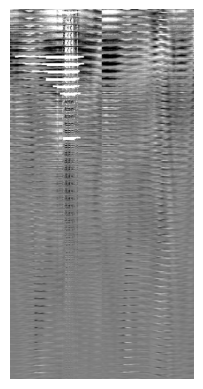

In [51]:
# from matplotlib import pyplot as plt

IMAGE_STACK_MODE = 3
img = gen_image_v2( train_image_path, 
                  fn = 'Ntqusw7xpb', 
                  plant_number = 1, 
                  side = 'L', 
                  left_slide = 1,
                  right_slide = -1,
                  start = 1, 
                  end = 50, 
                  min_stack = 50,
                  max_stack = 50,
                  cropped = False,
                  segment_width = 150,
                  mask_stage = 'full',
                  flip = 0,
                  rotate = 0)

plt.imshow(img)
plt.axis('off')
plt.show()

In [33]:
# plt.imshow(np.concatenate((stack_img, rgb_mask), axis=1))
# plt.axis('off')
# plt.show()

# df_train.loc[0]

In [34]:
class ImageDataset(Dataset):
    def __init__( self, 
                  df, 
                  image_path, 
                  img_comb, 
                  xtracols = None,
                  normalizer = None, 
                  top_val = 2.8, 
                  topval_method = 1, 
                  image_size = None, 
                  cropped = False, 
                  max_stack = 20,
                  min_stack = 20,
                  segment_width = 200):

        self.df = df
        self.image_path = image_path
        self.img_comb = img_comb
        self.normalizer = normalizer
        self.top_val = top_val
        self.topval_method = topval_method
        self.image_size = image_size
        self.min_stack = min_stack
        self.max_stack = max_stack
        self.cropped = cropped
        self.segment_width = segment_width
        self.xtracols = xtracols

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # img = imread(f"{self.image_path}/{self.df.iloc[idx][0]}")[:,:,self.img_comb]

        fn = self.df.iloc[idx].FolderName
        plant_n = self.df.iloc[idx].PlantNumber
        left_slide = self.df.iloc[idx].LeftSlide
        right_slide = self.df.iloc[idx].RightSlide
        side = self.df.iloc[idx].Side
        start = self.df.iloc[idx].Start
        end = self.df.iloc[idx].End
        stage = self.df.iloc[idx].Stage.lower()
        flip = self.df.iloc[idx].flip
        rotate = self.df.iloc[idx].rotate
        # target = float(self.df.iloc[idx].RootVolume)
        
        if self.topval_method == 1:
            img = gen_image_v1(self.image_path, fn, plant_n, side, start, end, self.cropped)
        elif self.topval_method == 2:
            img = gen_image_v2( img_path = self.image_path, 
                                fn = fn, 
                                plant_number = plant_n, 
                                side = side, 
                                left_slide = left_slide,
                                right_slide = right_slide,
                                start = start, 
                                end = end,
                                min_stack = self.min_stack,
                                max_stack = self.max_stack, 
                                cropped = self.cropped,
                                segment_width = self.segment_width,
                                mask_stage = stage,
                                flip = flip,
                                rotate = rotate)


        # if self.df.iloc[idx]['flip'] == 1:
        #     img = np.flip(img, axis=1)
            
        # if self.df.iloc[idx]['rotate'] > 0:
        #     img = np.rot90(img, k=self.df.iloc[idx]['rotate'], axes=(0, 1))
        
        # img = cv2.resize(img, image_size, interpolation=cv2.INTER_CUBIC)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # -------------- Augmentation Method -----------------------------
        # img = np.transpose(img, (2, 0, 1)).astype(np.float32) * 255.0
        # img = img * self.top_val
        
        # -------------- NON Augmentation Method -----------------------------
        # img = np.transpose(img, (2, 0, 1)).astype(np.float32).clip(0, 1.0) #.clip(0, 3.0)
        # img = (img-img.min())/(img.max()-img.min()) #obsolete

        
        img = img * 255
        img = img.astype(np.uint8)
        img = cv2.resize(img, self.image_size, interpolation=cv2.INTER_CUBIC)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.transpose(img, (2, 0, 1)).astype(np.float32)
        img = img / 255.0
        img = img * self.top_val

        # if self.normalizer:
        #     img = self.normalizer(img)
        
        return img.astype(np.float32)

In [35]:
# # iml = ImageDataset(df_train, train_image_path, [0,1,2], None, top_val=1.0, topval_method=1, image_size=(300,300))

# iml = ImageDataset( df_train, 
#                   train_image_path, 
#                   [0,1,2], 
#                   None, 
#                   top_val = 2.0, 
#                   topval_method = 2, 
#                   image_size = (300,300), 
#                   cropped = True, 
#                   min_stack = 80,
#                   max_stack = 81,
#                   segment_width = 1000)


# myloader = iter(iml)

In [36]:
# im = next(myloader)
# plt.imshow(np.transpose(im, (1,2,0)))

In [37]:
import os

def getXTrain(xtrain_par, d_type, save_xtrain = False):
    global df_train, df_test
    
    model_name = xtrain_par['timm_model']
    top_val_ = xtrain_par['topval']
    topval_method = xtrain_par['topval_method']
    img_comb = xtrain_par['timm_channel']
    img_minstack = xtrain_par['min_stack']
    img_maxstack = xtrain_par['max_stack']
    img_cropped = xtrain_par['cropped']
    segment_width = xtrain_par['segment_width']
    
    mn = model_name.replace("/", "__")
    XTrain_fn = f"X{d_type}_{mn}_{img_comb}_{topval_method}_{top_val_}_{img_cropped}.pkl"

    # if os.path.exists(f"{root_path}/XTRAIN/{XTrain_fn}"):
    #     X_train = pickle.load(open(f"{root_path}/XTRAIN/{XTrain_fn}", "rb"))['X_Train']
    #     return X_train

    maker_data = { "model_name": model_name,
                   "topval_method" : topval_method,
                   "img_comb" : img_comb,
                   "top_val_": top_val_,
                   "img_cropped": img_cropped,
                 }

    
    print("Train Pars", "top_val", top_val_, '>', img_comb,":", topval_method, model_name, img_cropped)

    comb_len = len(img_comb)
    
    model = timm.create_model(
        model_name,
        pretrained=True,
        in_chans=len(img_comb),
        num_classes=0,  # remove classifier nn.Linear
    )
    model = model.eval()
    model.to(device)

    # get model specific transforms (normalization, resize)
    data_config = timm.data.resolve_model_data_config(model)

    if comb_len == 3:
        normalizer = transforms.Normalize(mean=data_config['mean'], std=data_config['std'])
    else:
        mean_ = data_config['mean']
        std_ = data_config['std']
        
        new_mean = np.copy(mean_)
        new_std = np.copy(std_)

        for i in range(comb_len-3):
            new_mean = np.concatenate((new_mean, [np.mean(mean_)]))
            new_std = np.concatenate((new_std, [np.mean(std_)]))

        normalizer = transforms.Normalize(mean=new_mean, std=new_std)
        
    image_size = data_config['input_size'][1:]

    X_train = None

    if d_type == 'TRAIN':
        image_dataset = ImageDataset( df_train, 
                                      train_image_path, 
                                      img_comb, 
                                      normalizer, 
                                      top_val = top_val_, 
                                      topval_method = topval_method, 
                                      image_size = image_size, 
                                      cropped = img_cropped, 
                                      min_stack = img_minstack,
                                      max_stack = img_maxstack,
                                      segment_width = segment_width )
        Y_train = df_train['RootVolume'].values
    else:
        image_dataset = ImageDataset( df_test, 
                                      test_image_path, 
                                      img_comb, 
                                      normalizer, 
                                      top_val = top_val_, 
                                      topval_method = topval_method, 
                                      image_size = image_size, 
                                      cropped = img_cropped, 
                                      min_stack = img_minstack,
                                      max_stack = img_maxstack,
                                      segment_width = segment_width )
        Y_train = np.zeros((len(df_test), ))

    image_dataloader = DataLoader(image_dataset, batch_size=32, shuffle=False)

    with torch.no_grad():
        
        start_idx = 0

        start_time = time.time()
        time_is_ok = True
        time_check = True
        
        for imgs in tqdm(image_dataloader):
            for i in range(len(imgs)):
                imgs[i] = normalizer(imgs[i])

            # if self.flip == 1:
            #     img = np.flip(img, axis=1)
                
            # if self.rotate > 0:
            #     img = np.rot90(img, k=self.rotate, axes=(0, 1))

            imgs = imgs.to(device)

            output = model(imgs)
            # output = model.forward_features(imgs)
            # output = model.forward_head(output, pre_logits=True)

            output = output.detach().cpu().numpy()
            
            if X_train is None:
                X_train = np.zeros((len(Y_train), output.shape[1]))

            batch_size = imgs.size(0)
            end_idx = start_idx + batch_size
            X_train[start_idx:end_idx] = output
            start_idx = end_idx

            del imgs
            gc.collect()

    del model
    del image_dataset
    del image_dataloader
    gc.collect()
    torch.cuda.empty_cache()

    if save_xtrain:
        pickle.dump({"maker_data" : maker_data,
                     "X_Train": X_train}, open(f"{root_path}/XTRAIN/{XTrain_fn}", "wb"))

    return X_train

In [38]:
# def extract_features(image):
#     # # Baca gambar sebagai grayscale
#     # image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

#     black_pixels = np.sum(image == 0)
#     total_pixels = image.size
#     black_ratio = black_pixels / total_pixels
#     area = np.sum(image < 1.0)
#     return [black_ratio, area]

# def extract_features(image):
#     hist_data = np.histogram(image)
#     hist_n = hist_data[0]/hist_data[0].sum()
#     return np.concatenate((hist_n, hist_data[1]))

def extract_features(image):
    
    hist_data = np.histogram(image, bins = np.arange(0.0,1.1,0.1))
    hist_n = hist_data[0]/hist_data[0].sum()
    
    return hist_n

In [39]:
import os

def getXTrain2(xtrain_par, d_type, save_xtrain = False):
    global df_train, df_test, imgs
    
    top_val_ = xtrain_par['topval']
    topval_method = xtrain_par['topval_method']
    img_comb = xtrain_par['timm_channel']
    img_minstack = xtrain_par['min_stack']
    img_maxstack = xtrain_par['max_stack']
    img_cropped = xtrain_par['cropped']
    segment_width = xtrain_par['segment_width']
        
    image_size = (100,100)

    if d_type == 'TRAIN':
        image_dataset = ImageDataset( df_train, 
                                      train_image_path, 
                                      img_comb, 
                                      normalizer = None, 
                                      top_val = top_val_, 
                                      topval_method = topval_method, 
                                      image_size = image_size, 
                                      cropped = img_cropped, 
                                      min_stack = img_minstack,
                                      max_stack = img_maxstack,
                                      segment_width = segment_width )
        Y_train = df_train['RootVolume'].values
    else:
        image_dataset = ImageDataset( df_test, 
                                      test_image_path, 
                                      img_comb, 
                                      normalizer = None, 
                                      top_val = top_val_, 
                                      topval_method = topval_method, 
                                      image_size = image_size, 
                                      cropped = img_cropped, 
                                      min_stack = img_minstack,
                                      max_stack = img_maxstack,
                                      segment_width = segment_width )
        Y_train = np.zeros((len(df_test), ))

    image_dataloader = DataLoader(image_dataset, batch_size=32, shuffle=False)

    X_train = None
    start_idx = 0
    
    for imgs in tqdm(image_dataloader):

        output = []
        for img in imgs:
            output.append(extract_features(img))

        if X_train is None:
            X_train = np.zeros((len(Y_train), len(output[0])))
        
        batch_size = imgs.size(0)
        end_idx = start_idx + batch_size
        X_train[start_idx:end_idx] = output
        start_idx = end_idx

        del imgs
        gc.collect()

    del image_dataset
    del image_dataloader
    gc.collect()

    return X_train

In [40]:
from sklearn import neural_network

def train_svr(X_Train, Y_Train_Raw, TRAIN_METHOD, X_Test):
    global run_device

    xtrans_method = TRAIN_METHOD["xtrans_method"]
    ytrans_method = TRAIN_METHOD["ytrans_method"]

    base_model = TRAIN_METHOD['base_model']

    X_test = None
    
    if xtrans_method == 'standard_scaler':
        xscaler = StandardScaler()
        X_train = xscaler.fit_transform(X_Train)
        np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0, copy=False)
        if X_Test is not None:
            X_test = xscaler.transform(X_Test)
            np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0, copy=False)
    elif xtrans_method == 'log':
        X_train = np.log1p(X_Train)
        np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0, copy=False)
        if X_Test is not None:
            X_test = np.log1p(X_Test)
            np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0, copy=False)
    else:
        X_train = X_Train
        X_test = X_Test

    ytrans_method = TRAIN_METHOD["ytrans_method"]

    if ytrans_method == 'standard_scaler':
        yscaler = StandardScaler()
        Y_train = yscaler.fit_transform(Y_Train_Raw.reshape(-1,1)).reshape(-1)
    elif ytrans_method == 'log':
        Y_train = np.log1p(Y_Train_Raw)
    else:
        Y_train = Y_Train_Raw
    
    best_p_corr = np.inf
    fea_cnt = len(X_train[0])

    model_pars = TRAIN_METHOD['model_params']
    with_cv = TRAIN_METHOD['with_cv']

    print(f"{base_model} pars {str(model_pars)[:10]};{fea_cnt}", end = ">")

    if TRAIN_METHOD['taken_indices'] == 'all':
        taken_indices = np.arange(0, fea_cnt)
    else:
        taken_indices = TRAIN_METHOD['taken_indices']

    oof_pred = np.zeros((len(Y_train)))
    fold_scores = np.zeros((FOLD_CNT,))

    test_preds = []

    if with_cv:
        FOLD_CNT_ = FOLD_CNT
    else:
        FOLD_CNT_ = 1
                
    for fold in range(FOLD_CNT_):
        if FOLD_CNT_ == 1:
            train_idxs = np.arange(len(Y_train))
            val_idxs = np.arange(len(Y_train))            
        else:
            train_idxs = trainval_indexes[fold][0]
            val_idxs = trainval_indexes[fold][1]

        if base_model == 'svr':
            reg = SVR(**model_pars)
        elif base_model == 'lgb':
            reg = lgb.LGBMRegressor(**model_pars,
                                      verbose = -1, 
                                      n_jobs = -1,
                                      # n_estimators = 100, 
                                      # learning_rate = 0.01,
                                      device = run_device, 
                                      random_state = 42,
                                   )
        elif base_model == 'xgb':
            reg = xgb.XGBoostRegressor(**model_pars,
                                           verbosity = -1,
                                           device = run_device,
                                           random_state = 42,
                                       )
        elif base_model == 'cat':
            reg = cat.CatBoostRegressor(**model_pars,
                                           verbose=False,
                                           task_type = run_device.upper(),
                                           random_state = 42,
                                       )
        elif base_model == 'ridge':
            reg = linear_model.Ridge(**model_pars, random_state = 42)
        elif base_model == 'mlp':
            reg = neural_network.MLPRegressor(**model_pars, random_state = 42)
        elif base_model == 'lreg':
            reg = linear_model.LinearRegression(**model_pars)
            
        reg.fit(X_train[train_idxs][:,taken_indices], Y_train[train_idxs])                            
        
        y_pred = reg.predict(X_train[val_idxs][:,taken_indices])
        
        if X_test is not None:
            test_pred = reg.predict(X_test[:,taken_indices])
        else:
            test_pred = None

        if ytrans_method == 'standard_scaler':
            y_pred = yscaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)

            if test_pred is not None:
                test_pred = yscaler.inverse_transform(test_pred.reshape(-1, 1)).reshape(-1)
        elif ytrans_method == 'log':
            y_pred = np.expm1(y_pred)
            if test_pred is not None:
                test_pred = np.expm1(test_pred)
        else:
            pass
        
        rmse = root_mean_squared_error(Y_Train_Raw[val_idxs], y_pred)

        test_preds.append(test_pred)
        oof_pred[val_idxs] = y_pred
        fold_scores[fold] = rmse

        print(f" {fold}:{rmse:.4f}", end="")

    rmse = root_mean_squared_error(Y_Train_Raw, oof_pred)

    best_p_corr = min(best_p_corr, rmse)
    
    # TRAIN_SCORES.append([img_comb, model_name, f'{base_model}_C_{C}', oof_pred, pearson_corr, rmse, top_val_, fold_scores, taken_indices, topval_method, XTrain_fn])
    # pickle.dump(TRAIN_SCORES, open(SAVE_FILE_NAME, "wb"))

    print(f" OOF> : {rmse:.4f} (best {best_p_corr:.4f})")
    # print("-" * 50)

    return oof_pred, test_preds

In [41]:
# from sklearn import neural_network
# import copy

# def train_svr(X_Train, Y_Train_Raw, TRAIN_METHOD, X_Test):
#     global run_device

#     xtrans_method = TRAIN_METHOD["xtrans_method"]
#     ytrans_method = TRAIN_METHOD["ytrans_method"]

#     base_model = TRAIN_METHOD['base_model']

#     X_test = None
    
#     if xtrans_method == 'standard_scaler':
#         xscaler = StandardScaler()
#         X_train = xscaler.fit_transform(X_Train)
#         np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0, copy=False)
#         if X_Test is not None:
#             X_test = xscaler.transform(X_Test)
#             np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0, copy=False)
#     elif xtrans_method == 'log':
#         X_train = np.log1p(X_Train)
#         np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0, copy=False)
#         if X_Test is not None:
#             X_test = np.log1p(X_Test)
#             np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0, copy=False)
#     else:
#         X_train = X_Train
#         X_test = X_Test

#     ytrans_method = TRAIN_METHOD["ytrans_method"]

#     if ytrans_method == 'standard_scaler':
#         yscaler = StandardScaler()
#         Y_train = yscaler.fit_transform(Y_Train_Raw.reshape(-1,1)).reshape(-1)
#     elif ytrans_method == 'log':
#         Y_train = np.log1p(Y_Train_Raw)
#     else:
#         Y_train = Y_Train_Raw
    
#     best_p_corr = np.inf
#     fea_cnt = len(X_train[0])

#     model_pars = TRAIN_METHOD['model_params']
#     with_cv = TRAIN_METHOD['with_cv']

#     first_scan = True
#     best_taken_indices = []
    
#     improved = True
    
#     while improved:
        
#         improved = False
        
#         for scanidx in range(fea_cnt):

#             print(f"{base_model} pars {str(model_pars)[:10]};{scanidx}/{fea_cnt}", end = ">")
    
#             if first_scan:
#                 taken_indices = [scanidx]
#             else:
#                 taken_indices = best_taken_indices + [scanidx]
        
#             oof_pred = np.zeros((len(Y_train)))
#             fold_scores = np.zeros((FOLD_CNT,))
        
#             test_preds = []
        
#             if with_cv:
#                 FOLD_CNT_ = FOLD_CNT
#             else:
#                 FOLD_CNT_ = 1
                        
#             for fold in range(FOLD_CNT_):
#                 if FOLD_CNT_ == 1:
#                     train_idxs = np.arange(len(Y_train))
#                     val_idxs = np.arange(len(Y_train))            
#                 else:
#                     train_idxs = trainval_indexes[fold][0]
#                     val_idxs = trainval_indexes[fold][1]
        
#                 if base_model == 'svr':
#                     reg = SVR(**model_pars)
#                 elif base_model == 'lgb':
#                     reg = lgb.LGBMRegressor(**model_pars,
#                                               verbose = -1, 
#                                               n_jobs = -1,
#                                               # n_estimators = 100, 
#                                               # learning_rate = 0.01,
#                                               device = run_device, 
#                                               random_state = 42,
#                                            )
#                 elif base_model == 'xgb':
#                     reg = xgb.XGBoostRegressor(**model_pars,
#                                                    verbosity = -1,
#                                                    device = run_device,
#                                                    random_state = 42,
#                                                )
#                 elif base_model == 'cat':
#                     reg = cat.CatBoostRegressor(**model_pars,
#                                                    verbose=False,
#                                                    task_type = run_device.upper(),
#                                                    random_state = 42,
#                                                )
#                 elif base_model == 'ridge':
#                     reg = linear_model.Ridge(**model_pars, random_state = 42)
#                 elif base_model == 'mlp':
#                     reg = neural_network.MLPRegressor(**model_pars, random_state = 42)
#                 elif base_model == 'lreg':
#                     reg = linear_model.LinearRegression(**model_pars)
                    
#                 reg.fit(X_train[train_idxs][:,taken_indices], Y_train[train_idxs])                            
                
#                 y_pred = reg.predict(X_train[val_idxs][:,taken_indices])
                
#                 if X_test is not None:
#                     test_pred = reg.predict(X_test[:,taken_indices])
#                 else:
#                     test_pred = None
        
#                 if ytrans_method == 'standard_scaler':
#                     y_pred = yscaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)
        
#                     if test_pred is not None:
#                         test_pred = yscaler.inverse_transform(test_pred.reshape(-1, 1)).reshape(-1)
#                 elif ytrans_method == 'log':
#                     y_pred = np.expm1(y_pred)
#                     if test_pred is not None:
#                         test_pred = np.expm1(test_pred)
#                 else:
#                     pass
                
#                 rmse = root_mean_squared_error(Y_Train_Raw[val_idxs], y_pred)
        
#                 test_preds.append(test_pred)
#                 oof_pred[val_idxs] = y_pred
#                 fold_scores[fold] = rmse
        
#                 print(f" {fold}:{rmse:.4f}", end="")
        
#             rmse = root_mean_squared_error(Y_Train_Raw, oof_pred)
        
#             if best_p_corr >= rmse:
#                 best_p_corr = rmse
#                 best_taken_indices = copy.deepcopy(taken_indices)
#                 improved = True
            
#             # TRAIN_SCORES.append([img_comb, model_name, f'{base_model}_C_{C}', oof_pred, pearson_corr, rmse, top_val_, fold_scores, taken_indices, topval_method, XTrain_fn])
#             # pickle.dump(TRAIN_SCORES, open(SAVE_FILE_NAME, "wb"))
        
#             print(f" OOF> : {rmse:.4f} (best {best_p_corr:.4f} @ {len(best_taken_indices)})")
#             # print("-" * 50)

#         first_scan = False

#     print(best_taken_indices)
#     return oof_pred, test_preds

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import random

class BinaryDataset(Dataset):
    def __init__(self, features, labels):
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, 
                 dense1=128, dense2=64,  # Ukuran dense layer
                 batchnorm1=True, batchnorm2=True,  # Aktifkan batch normalization
                 do1=0.5, do2=0.5  # Dropout rate
                ):
        super(NeuralNetwork, self).__init__()

        layers = []

        # Layer 1
        layers.append(nn.Linear(input_dim, dense1))
        if batchnorm1:
            layers.append(nn.BatchNorm1d(dense1))
            
        layers.append(nn.ReLU())
        if do1 > 0:
            layers.append(nn.Dropout(do1))

        # Layer 2
        layers.append(nn.Linear(dense1, dense2))
        if batchnorm2:
            layers.append(nn.BatchNorm1d(dense2))
            
        layers.append(nn.ReLU())
        if do2 > 0:
            layers.append(nn.Dropout(do2))

        # Output Layer
        layers.append(nn.Linear(dense2, 1))
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)  # Gabungkan semua layer

    def forward(self, x):
        return self.model(x)

# Training and Validation Functions
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X).squeeze()
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X).squeeze()
            loss = criterion(outputs, y)
            running_loss += loss.item()
    return running_loss / len(dataloader)

def train_torch_v1(X_train, Y_Train_Raw, TRAIN_METHOD, X_Test, PREDICT_TEST = True):

    xtrans_method = TRAIN_METHOD["xtrans_method"]
    ytrans_method = TRAIN_METHOD["ytrans_method"]

    X_test = None
    
    if xtrans_method == 'standard_scaler':
        xscaler = StandardScaler()
        X_train = xscaler.fit_transform(X_Train)
        np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0, copy=False)
        if X_Test is not None:
            X_test = xscaler.transform(X_Test)
            np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0, copy=False)
    elif xtrans_method == 'log':
        X_train = np.log1p(X_Train)
        np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0, copy=False)
        if X_Test is not None:
            X_test = np.log1p(X_Test)
            np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0, copy=False)
    else:
        X_train = X_Train
        X_test = X_Test

    if ytrans_method == 'standard_scaler':
        yscaler = StandardScaler()
        Y_train = yscaler.fit_transform(Y_Train_Raw.reshape(-1,1)).reshape(-1)
    elif ytrans_method == 'log':
        Y_train = np.log1p(Y_Train_Raw)
    else:
        Y_train = Y_Train_Raw
    

    params = TRAIN_METHOD['model_params']
    
    input_dim = len(X_train[0])
    batch_size = params['batch_size']
    learning_rate = params['learning_rate']
    num_epochs = params['num_epochs']
    patience = params['patience']

    
    oof_preds = np.zeros((len(X_train),))    
    test_preds = []

    for fold in range(FOLD_CNT):
        
        train_idxs = trainval_indexes[fold][0]
        val_idxs = trainval_indexes[fold][1]
                
        train_dataset = BinaryDataset(X_train[train_idxs][:], Y_train[train_idxs])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        val_dataset = BinaryDataset(X_train[val_idxs][:], Y_train[val_idxs])
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
        set_seed(42)
    
        model = NeuralNetwork(input_dim=input_dim,
                              dense1 = params['dense1'],
                              dense2 = params['dense2'],
                              batchnorm1 = params['batchnorm1'],
                              batchnorm2 = params['batchnorm2'],
                              do1 = params['do1'],
                              do2 = params['do2'],
                              ).to(device)
        
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
    
        checkpoint_path = f"./best_model_v1.1_F{fold}.pth"
    
        best_val_loss = float('inf')
    
        for epoch in range(num_epochs):
            train_loss = train(model, train_loader, criterion, optimizer, device)
            val_loss = validate(model, val_loader, criterion, device)
            scheduler.step(val_loss)
    
            # print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}", end = "")
            sys.stdout.write(f"\r Fold {fold} Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} -----")
    
            # Save the best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), checkpoint_path)
                early_stop_counter = 0
                # print(f"--improve")
            else:
                early_stop_counter += 1
                # print()
    
            # Early stopping
            if early_stop_counter >= patience:
                # print("Early stopping triggered.")
                break
        print()
        
        model.load_state_dict(torch.load(checkpoint_path, weights_only = True))
        
        data_tensor = torch.tensor(X_train[val_idxs][:], dtype=torch.float32)
        data_tensor = data_tensor.to(device)
        
        # Model harus dalam mode evaluasi
        model.eval()
        
        # Inferensi
        with torch.no_grad():
            predictions = model(data_tensor)
                    
        val_predictions = predictions.detach().cpu().numpy().reshape(-1)

        if ytrans_method == 'standard_scaler':
            val_predictions = yscaler.inverse_transform(val_predictions.reshape(-1, 1)).reshape(-1)
        elif ytrans_method == 'log':
            val_predictions = np.expm1(val_predictions.reshape(-1))
        else:
            val_predictions = val_predictions.reshape(-1)
            

        np.nan_to_num(val_predictions, nan=0.0, posinf=0.0, neginf=0.0, copy=False)
        
        oof_preds[val_idxs] = val_predictions
        fold_score = metrics.root_mean_squared_error(Y_Train_Raw[val_idxs], val_predictions)
    
        print(f"F{fold} {fold_score:.5f}, ")

        if X_test is not None:
            test_predictions = model(torch.from_numpy(X_test[:]).float().to(device))

            test_predictions = test_predictions.detach().cpu().numpy()
            np.nan_to_num(test_predictions, nan=0.0, posinf=0.0, neginf=0.0, copy=False)

            if ytrans_method == 'standard_scaler':
                test_predictions = yscaler.inverse_transform(test_predictions.reshape(-1, 1)).reshape(-1)
            elif ytrans_method == 'log':
                test_predictions = np.expm1(test_predictions.reshape(-1))
            else:
                test_predictions = test_predictions.reshape(-1)

            np.nan_to_num(test_predictions, nan=0.0, posinf=0.0, neginf=0.0, copy=False)
        else:
            test_predictions = None

        test_preds.append(test_predictions)
        print("")

    oof_score = metrics.root_mean_squared_error(Y_Train_Raw, oof_preds)
    # train_history.append(fold_train_history)
    
    print(f'oof_score: {oof_score:.4f}')
    print("\n", "-" * 50)

    return oof_preds, test_preds

In [43]:
# TRAIN_PARAMS = [
#     {
#         'with_xtra_col' : True,
#         'margin_shrink' : 1.15,
#         'timm_model' : 'timm/vit_base_patch16_224.sam_in1k',
#         "timm_channel": [0, 1, 2],
#         'topval' : 2.0,
#         'topval_method' : 2,
#         'min_stack' : 80,
#         'max_stack' : 80,
#         'cropped' : False,

#         'IMAGE_STACK_MODE' : 3,
#         'offset' : 8,
#         'MARGIN_MODE' : None,
        
#         "xtrans_method": "-",
#         "ytrans_method": "log",
#         "with_cv" : True,
#         'base_model' : 'lgb',
#         "model_params": { 
#             # "C": 1.0
#             # 'random_state' : 42
#         },
#         "taken_indices": "all",
#         "model_weight": 1.0,
#         'model_score' : 1.2519497752787698,
#     }
    
# ]

In [44]:
TRAIN_PARAMS = [
    # {
    #     'with_xtra_col' : True,
    #     'margin_shrink' : 1.15, #1.15,
    #     'timm_model' : 'timm/vit_base_patch16_224.sam_in1k',
    #     "timm_channel": [0, 1, 2],
    #     'topval' : 1.0,
    #     'topval_method' : 2,
    #     'min_stack' : 80,
    #     'max_stack' : 80,
    #     'cropped' : False,

    #     'IMAGE_STACK_MODE' : 0,
    #     'offset' : 0,
    #     'MARGIN_MODE' : 3,
        
    #     "xtrans_method": "-",
    #     "ytrans_method": "-",
    #     "with_cv" : True,
    #     'base_model' : 'cat',
    #     "model_params": { 
    #         # "C": 1.0
    #         # 'random_state' : 42
    #     },
    #     "taken_indices": "all",
    #     "model_weight": 1.0,
    #     'model_score' : 1.2914934035844599,
    # },
    # {
    #     'with_xtra_col' : True,
    #     'margin_shrink' : 1.15, #1.15,
    #     'timm_model' : 'timm/vit_base_patch16_224.sam_in1k',
    #     "timm_channel": [0, 1, 2],
    #     'topval' : 1.0,
    #     'topval_method' : 2,
    #     'min_stack' : 80,
    #     'max_stack' : 80,
    #     'cropped' : False,

    #     'IMAGE_STACK_MODE' : 0,
    #     'offset' : 0,
    #     'MARGIN_MODE' : 3,
        
    #     "xtrans_method": "-",
    #     "ytrans_method": "-",
    #     "with_cv" : True,
    #     'base_model' : 'lreg',
    #     "model_params": { 
    #         # "C": 1.0
    #         # 'random_state' : 42
    #     },
    #     "taken_indices": "all",
    #     "model_weight": 1.0,
    #     'model_score' : 1.2914934035844599,
    # },
    #  {
    #     'with_xtra_col' : True,
    #     'margin_shrink' : 1.0, #1.15,
    #     'timm_model' : 'timm/vit_base_patch16_224.augreg2_in21k_ft_in1k', #'timm/vit_base_patch16_224.augreg2_in21k_ft_in1k',
    #     "timm_channel": [0, 1, 2],
    #     'topval' : 2.0,
    #     'topval_method' : 2,
    #     'min_stack' : 80,
    #     'max_stack' : 80,
    #     'cropped' : False,

    #     'IMAGE_STACK_MODE' : 7,
    #     'offset' : [-3, 0, 3],
    #     'MARGIN_MODE' : 3,
    #     "xtrans_method": "-",
    #     "ytrans_method": "-",
    #     "with_cv" : True,
    #     'base_model' : 'svr',
    #     "model_params": { 
    #         "C": 1.0
    #         # 'random_state' : 42
    #     },
    #     "taken_indices": [769, 0, 1, 4, 8, 16, 24, 27, 28, 29, 31, 46, 58, 59, 61, 63, 65, 66, 69, 71, 75, 76, 77, 78, 79, 86, 90, 91, 103, 104, 111, 116, 119, 124, 136, 137, 144, 147, 149, 153, 156, 157, 165, 170, 182, 183, 187, 191, 198, 200, 203, 209, 213, 215, 216, 227, 229, 237, 245, 246, 247, 254, 255, 261, 266, 267, 268, 273, 281, 296, 301, 313, 314, 324, 339, 342, 343, 345, 351, 360, 365, 386, 387, 405, 410, 426, 430, 436, 440, 456, 457, 462, 464, 470, 474, 475, 482, 484, 485, 487, 493, 507, 529, 543, 544, 547, 550, 552, 564, 598, 628, 636, 640, 644, 661, 694, 702, 705, 713, 747, 758, 762, 767, 770, 4, 10, 29, 40, 57, 76, 79, 94, 100, 112, 116, 124, 140, 144, 147, 153, 215, 225, 245, 247, 267, 268, 313, 324, 333, 342, 345, 351, 365, 387, 430, 456, 470, 474, 484, 487, 500, 507, 508, 523, 529, 543, 544, 545, 547, 557, 564, 597, 644, 658, 672, 675, 713, 744, 747, 758, 762, 767, 769, 770, 6, 31, 58, 62, 76, 79, 86, 94, 100, 124, 140, 147, 156, 174, 203, 211, 215, 216, 238, 245, 246, 247, 248, 254, 273, 301, 356, 360, 365, 377, 430, 456, 474, 484, 487, 493, 523, 547, 564, 612, 614, 636, 644, 675, 695, 702, 705, 713, 741, 744, 747, 770, 8, 16, 27, 29, 57, 58, 86, 126, 137, 147, 216, 231, 245, 267, 275, 313, 351, 360, 365, 430, 431, 456, 474, 475, 484, 523, 547, 557, 636, 644, 744, 747, 762, 767, 770, 29, 58, 124, 137, 147, 211, 216, 227, 245, 267, 289, 290, 301, 313, 360, 364, 365, 387, 430, 484, 485, 508, 523, 547, 564, 644, 713, 747, 751, 758, 767, 29, 76, 137, 183, 216, 267, 275, 313, 342, 351, 410, 470, 484, 523, 547, 644, 672, 713, 744, 747, 758, 762, 767, 770, 29, 31, 76, 83, 90, 137, 153, 245, 246, 267, 268, 289, 313, 324, 342, 360, 365, 387, 430, 475, 484, 487, 523, 547, 644, 694, 713],
    #     "model_weight": 1.0,
    #     'model_score' : 1.2914934035844599,
    # },
		{
			"with_xtra_col": True,
			"margin_shrink": 1.3,
			"timm_model": "timm/vit_base_patch16_224.augreg2_in21k_ft_in1k",
			"timm_channel": [
				0,
				1,
				2
			],
			"topval": 2.0,
			"topval_method": 2,
			"min_stack": 40,
			"max_stack": 40,
			"cropped": False,
			"IMAGE_STACK_MODE": 3,
			"offset": 6,
			"MARGIN_MODE": 3,
			"xtrans_method": "-",
			"ytrans_method": "-",
			"with_cv": True,
			"base_model": "lgb",
			"model_params": {},
			"taken_indices": "all",
			"model_weight": 1.0,
			"model_score": 1.2519497752787699,
			"segment_width": 109
		}
]

In [45]:
import os
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
import catboost as cat
import xgboost as xgb
import copy
import pickle


best_kfold_score = np.inf
global_best_model_score = np.inf

if str(device) == 'cuda':
    run_device = 'gpu'
else:
    run_device = 'cpu'

all_test_preds = []
seed = 42

BASE_PLANT_MARGIN = np.array([ [  20.0, 105.0 ],
                               [ 105.0, 190.0 ],
                               [ 190.0, 270.0 ],
                               [ 270.0, 365.0 ],
                               [ 365.0, 455.0 ],
                               [ 455.0, 545.0 ],
                               [ 545.0, 640.0 ],
                             ])


for train_param in TRAIN_PARAMS:

    # for timm_model in ['']
    
    PLANT_MARGIN = copy.deepcopy(BASE_PLANT_MARGIN)
    FOLD_CNT = 5
    
    with_xtra_col = train_param['with_xtra_col']
    margin_shrink = train_param['margin_shrink']
    timm_model = train_param['timm_model'] #'timm/swin_base_patch4_window7_224.ms_in22k' #
    MARGIN_MODE = train_param['MARGIN_MODE']
    topval_method = train_param['topval_method']
    min_stack = train_param['min_stack']
    max_stack = train_param['max_stack']
    offset = train_param['offset']
    IMAGE_STACK_MODE = train_param['IMAGE_STACK_MODE']
    cropped = train_param['cropped']
    topval_ = train_param['topval']

    TRAIN_METHOD = train_param#['xtrain']
    
    # TRAIN_METHOD['cropped'] = cropped
    # TRAIN_METHOD['min_stack'] = min_stack
    # TRAIN_METHOD['max_stack'] = max_stack
    # TRAIN_METHOD['topval'] = topval_
    # TRAIN_METHOD['timm_model'] = timm_model
    # TRAIN_METHOD['topval_method'] = topval_method
    # TRAIN_METHOD['segment_width'] = segment_width
    
    base_model = train_param['base_model']
    model_weight = train_param['model_weight']
    init_score = train_param['model_score']

    if True:
        
            if margin_shrink != 1.0:
                lebar_lama = PLANT_MARGIN[:, 1] - PLANT_MARGIN[:, 0]
                lebar_baru = lebar_lama * margin_shrink
                selisih = (lebar_lama - lebar_baru) / 2
                
                PLANT_MARGIN[:, 0] += selisih
                PLANT_MARGIN[:, 1] -= selisih  
                
                PLANT_MARGIN = PLANT_MARGIN.clip(0.0, 640.0)
            
            PLANT_MARGIN = PLANT_MARGIN / 640.0

            if MARGIN_MODE in [2,3]:
                plant7_width = PLANT_MARGIN[6][1] - PLANT_MARGIN[6][0]
                PLANT_MARGIN[0][1] = PLANT_MARGIN[0][0] + plant7_width
                PLANT_MARGIN[1][1] = PLANT_MARGIN[1][0] + plant7_width
                PLANT_MARGIN[2][1] = PLANT_MARGIN[2][0] + plant7_width
                PLANT_MARGIN[3][1] = PLANT_MARGIN[3][0] + plant7_width
                PLANT_MARGIN[4][1] = PLANT_MARGIN[4][0] + plant7_width
                PLANT_MARGIN[5][1] = PLANT_MARGIN[5][0] + plant7_width

            L_PLANT_MARGIN = PLANT_MARGIN
            # L_PLANT_MARGIN = 1-np.flip(np.flip(PLANT_MARGIN, axis=0), axis=1)
            base_segment_width = int(max(PLANT_MARGIN[:,1] - PLANT_MARGIN[:,0]) * 640)

            if True:

                if type(offset) == list:
                    df_train = generate_train_df( df_train_raw,
                                                  left_offset_list = offset,
                                                  right_offset_list = offset,
                                                  margin_mode = MARGIN_MODE,
                                                  is_train_data = True
                                                )
                    
                    df_test = generate_train_df( df_test_raw,
                                                  left_offset_list = offset,
                                                  right_offset_list = offset,
                                                  margin_mode = MARGIN_MODE,
                                                  is_train_data = False
                                                )
                elif offset > 0:
                    df_train = generate_train_df( df_train_raw,
                                                  left_offset_list = [-offset, 0, offset],
                                                  right_offset_list = [-offset, 0, offset],
                                                  margin_mode = MARGIN_MODE,
                                                  is_train_data = True
                                                )
                    
                    df_test = generate_train_df( df_test_raw,
                                                 left_offset_list = [-offset, 0, offset],
                                                 right_offset_list = [-offset, 0, offset],
                                                 margin_mode = MARGIN_MODE,
                                                 is_train_data = False
                                               )
                else:
                    df_train = generate_train_df( df_train_raw,
                                                  left_offset_list = [0], 
                                                  right_offset_list = [0],
                                                  margin_mode = MARGIN_MODE,
                                                  is_train_data = True
                                                )
                    
                    df_test = generate_train_df( df_test_raw,
                                                 left_offset_list = [0],
                                                 right_offset_list = [0],
                                                 margin_mode = MARGIN_MODE,
                                                 is_train_data = False
                                               )

                # df_train['flip'] = 0
                # df_train['rotate'] = 0
                
                Y_Train_Raw = df_train['RootVolume'].values
                pair_indices = df_train['PairIdx'].values
                train_xtra_val = df_train[['stack_count', 'Genotype_cat', 'Stage_cat']].values
                
                df_test['flip'] = 0
                df_test['rotate'] = 0
                test_Y_Train_Raw = df_test['RootVolume'].values
                test_pair_indices = df_test['PairIdx'].values
                test_xtra_val = df_test[['stack_count', 'Genotype_cat', 'Stage_cat']].values
                
                if True:

                    if IMAGE_STACK_MODE == 1:
                        segment_width = base_segment_width * 2
                    else:
                        segment_width = base_segment_width

                    TRAIN_METHOD['segment_width'] = segment_width
                
                    if True:
                        if True:
                            print("---", with_xtra_col, 
                                        margin_shrink, 
                                        cropped, 
                                        IMAGE_STACK_MODE, 
                                        min_stack, 
                                        max_stack, 
                                        topval_, 
                                        topval_method, 
                                        timm_model, 
                                        offset,
                                        MARGIN_MODE )

                            gkf = StratifiedGroupKFold(n_splits=FOLD_CNT, shuffle=True, random_state=seed)
                            stratifield_values = df_train['target_digit'].values
                            
                            trainval_indexes = []
                            for idx, (train_idx, val_idx) in enumerate(gkf.split(df_train, stratifield_values, df_train['FolderName'])):
                                print(len(train_idx), len(val_idx))
                                trainval_indexes.append([train_idx, val_idx])
                                
                            all_preds = []
                            
                            if True:
                                
                                print("***", base_model, ", init score", init_score)

                                X_Train = getXTrain(TRAIN_METHOD, 'TRAIN')
                                X_Test = getXTrain(TRAIN_METHOD, 'TEST')

                                if with_xtra_col:
                                    X_Train = np.concatenate((X_Train, train_xtra_val), axis=1)
                                    X_Test = np.concatenate((X_Test, test_xtra_val), axis=1)
                                
                                if base_model == 'transformer_v3':
                                    y_preds, test_preds = train_transformer_v3(X_Train, Y_Train_Raw, TRAIN_METHOD, X_Test)
                                elif base_model == 'transformer_v4':
                                    y_preds, test_preds = train_transformer_v4(X_Train, Y_Train_Raw, TRAIN_METHOD, X_Test)
                                elif base_model == 'train_torch_v1':
                                    y_preds, test_preds = train_torch_v1(X_Train, Y_Train_Raw, TRAIN_METHOD, X_Test, True)
                                else:
                                # if base_model in ['svr', 'lgb', 'cat', 'ridge']:
                                    y_preds, test_preds = train_svr(X_Train, Y_Train_Raw, TRAIN_METHOD, X_Test)

                                # ------------- Train post processing ----------------------------------------------------
                                new_ypreds = np.zeros((len(y_preds),))

                                for i, pairidx in enumerate(pair_indices):
                                    if pairidx < 0:
                                        new_ypreds[i] = y_preds[i]
                                    else:
                                        new_ypreds[i] = np.mean(y_preds[np.where(pair_indices == pairidx)[0]])

                                y_preds = new_ypreds

                                all_train_ids = df_train.ID.values
                                raw_train_ids = df_train_raw.ID.values
                                final_train_preds = np.zeros((len(raw_train_ids)))
                                
                                for idx_, id_ in enumerate(raw_train_ids):
                                    final_train_preds[idx_] = np.mean(new_ypreds[np.where(all_train_ids == id_)[0]])

                                
                                all_preds.append(y_preds)
                                
                                # ------------- END OF Train post processing ----------------------------------------------------
                                
                                test_preds = np.mean(test_preds, axis = 0)
                                
                                test_new_ypreds = np.zeros((len(test_preds),))

                                for i, pairidx in enumerate(test_pair_indices):
                                    if pairidx < 0:
                                        test_new_ypreds[i] = test_preds[i]
                                    else:
                                        test_new_ypreds[i] = np.mean(test_preds[np.where(test_pair_indices == pairidx)[0]])


                                all_test_ids = df_test.ID.values
                                raw_test_ids = df_test_raw.ID.values
                                final_test_preds = np.zeros((len(raw_test_ids)))
                                
                                for idx_, id_ in enumerate(raw_test_ids):
                                    final_test_preds[idx_] = np.mean(test_new_ypreds[np.where(all_test_ids == id_)[0]])
                                
                                all_test_preds.append(final_test_preds)
                                
                                # ------------- END OF Test post processing ----------------------------------------------------
    
                                model_score = metrics.root_mean_squared_error(Y_Train_Raw, y_preds)
                                model_raw_score = metrics.root_mean_squared_error(df_train_raw.RootVolume.values, final_train_preds)
                                
                                if global_best_model_score > model_score:
                                    global_best_model_score = model_score
    
                                # TRAIN_DATA.append([with_xtra_col, margin_shrink, cropped, min_stack, max_stack, topval_, topval_method, timm_model, IMAGE_STACK_MODE, offset, MARGIN_MODE, base_model, model_score, y_preds])
                                # pickle.dump({ "data_struct" : "with_xtra_col, margin_shrink, cropped, min_stack, max_stack, topval_, topval_method, timm_model, IMAGE_STACK_MODE, offset, MARGIN_MODE, base_model, model_score, y_preds",
                                #               'BASE_PLANT_MARGIN': BASE_PLANT_MARGIN,
                                #               "TRAIN_DATA" : TRAIN_DATA }, 
                                #             open( SAVE_TRAIN_FN, 'wb' ))
                                
                                print(f" >>> {model_score:.5f} ({model_raw_score:.5f}) best {global_best_model_score:.5f}")

final_score = metrics.root_mean_squared_error(Y_Train_Raw, np.mean(all_preds, axis = 0))

# XTRA_TRAIN_DATA = {'final_score' : final_score, 'USE_WEIGHT' : USE_WEIGHT}

if best_kfold_score > final_score:
    best_kfold_score = final_score

print(f"=============== ens {final_score:.5f}, best {best_kfold_score:.5f}")
# print("-" * 40)
    
    
            # clear_huggingface_cache()

print("Finish ...")

--- True 1.3 False 3 40 40 2.0 2 timm/vit_base_patch16_224.augreg2_in21k_ft_in1k 6 3
939 219
885 273
960 198
933 225
915 243
*** lgb , init score 1.2519497752787698
Train Pars top_val 2.0 > [0, 1, 2] : 2 timm/vit_base_patch16_224.augreg2_in21k_ft_in1k False


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

100%|██████████| 37/37 [00:48<00:00,  1.32s/it]


Train Pars top_val 2.0 > [0, 1, 2] : 2 timm/vit_base_patch16_224.augreg2_in21k_ft_in1k False


100%|██████████| 13/13 [00:16<00:00,  1.30s/it]


lgb pars {};771> 0:1.8595 1:1.5342 2:1.3376 3:1.4077 4:1.2811 OOF> : 1.4981 (best 1.4981)
 >>> 1.46303 (1.45120) best 1.46303
=============== ens 1.46303, best 1.46303
Finish ...


# Find best indices

In [46]:
# from sklearn import neural_network
# import copy
# from IPython.display import clear_output

# def train_scan(X_Train, Y_Train_Raw, TRAIN_METHOD, X_Test):
#     global run_device, best_taken_indices

#     xtrans_method = TRAIN_METHOD["xtrans_method"]
#     ytrans_method = TRAIN_METHOD["ytrans_method"]

#     base_model = TRAIN_METHOD['base_model']

#     TRAIN_DATA = []

#     X_test = None
    
#     if xtrans_method == 'standard_scaler':
#         xscaler = StandardScaler()
#         X_train = xscaler.fit_transform(X_Train)
#         np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0, copy=False)
#         if X_Test is not None:
#             X_test = xscaler.transform(X_Test)
#             np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0, copy=False)
#     elif xtrans_method == 'log':
#         X_train = np.log1p(X_Train)
#         np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0, copy=False)
#         if X_Test is not None:
#             X_test = np.log1p(X_Test)
#             np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0, copy=False)
#     else:
#         X_train = X_Train
#         X_test = X_Test

#     ytrans_method = TRAIN_METHOD["ytrans_method"]

#     if ytrans_method == 'standard_scaler':
#         yscaler = StandardScaler()
#         Y_train = yscaler.fit_transform(Y_Train_Raw.reshape(-1,1)).reshape(-1)
#     elif ytrans_method == 'log':
#         Y_train = np.log1p(Y_Train_Raw)
#     else:
#         Y_train = Y_Train_Raw
    
#     best_p_corr = np.inf
#     fea_cnt = len(X_train[0])

#     model_pars = TRAIN_METHOD['model_params']
#     with_cv = TRAIN_METHOD['with_cv']

#     first_scan = False
#     best_taken_indices = [769, 0, 1, 4, 8, 16, 24, 27, 28, 29, 31, 46, 58, 59, 61, 63, 65, 66, 69, 71, 75, 76, 77, 78, 79, 86, 90, 91, 103, 104, 111, 116, 119, 124, 136, 137, 144, 147, 149, 153, 156, 157, 165, 170, 182, 183, 187, 191, 198, 200, 203, 209, 213, 215, 216, 227, 229, 237, 245, 246, 247, 254, 255, 261, 266, 267, 268, 273, 281, 296, 301, 313, 314, 324, 339, 342, 343, 345, 351, 360, 365, 386, 387, 405, 410, 426, 430, 436, 440, 456, 457, 462, 464, 470, 474, 475, 482, 484, 485, 487, 493, 507, 529, 543, 544, 547, 550, 552, 564, 598, 628, 636, 640, 644, 661, 694, 702, 705, 713, 747, 758, 762, 767, 770, 4, 10, 29, 40, 57, 76, 79, 94, 100, 112, 116, 124, 140, 144, 147, 153, 215, 225, 245, 247, 267, 268, 313, 324, 333, 342, 345, 351, 365, 387, 430, 456, 470, 474, 484, 487, 500, 507, 508, 523, 529, 543, 544, 545, 547, 557, 564, 597, 644, 658, 672, 675, 713, 744, 747, 758, 762, 767, 769, 770, 6, 31, 58, 62, 76, 79, 86, 94, 100, 124, 140, 147, 156, 174, 203, 211, 215, 216, 238, 245, 246, 247, 248, 254, 273, 301, 356, 360, 365, 377, 430, 456, 474, 484, 487, 493, 523, 547, 564, 612, 614, 636, 644, 675, 695, 702, 705, 713, 741, 744, 747, 770, 8, 16, 27, 29, 57, 58, 86, 126, 137, 147, 216, 231, 245, 267, 275, 313, 351, 360, 365, 430, 431, 456, 474, 475, 484, 523, 547, 557, 636, 644, 744, 747, 762, 767, 770, 29, 58, 124, 137, 147, 211, 216, 227, 245, 267, 289, 290, 301, 313, 360, 364, 365, 387, 430, 484, 485, 508, 523, 547, 564, 644, 713, 747, 751, 758, 767, 29, 76, 137, 183, 216, 267, 275, 313, 342, 351, 410, 470, 484, 523, 547, 644, 672, 713, 744, 747, 758, 762, 767, 770, 29, 31, 76, 83, 90, 137, 153, 245, 246, 267, 268, 289, 313, 324, 342, 360, 365, 387, 430, 475, 484, 487, 523, 547, 644, 694, 713]
    
#     improved = True
    
#     while improved:
        
#         improved = False
        
#         for scanidx in range(-1,fea_cnt):

#             # if scanidx in best_taken_indices:
#             #     continue

#             print(f"{base_model} pars {str(model_pars)[:10]};{scanidx}/{fea_cnt}", end = ">")

            
#             if first_scan:
#                 taken_indices = [scanidx]
#             else:
#                 taken_indices = best_taken_indices + [scanidx]
        
#             oof_pred = np.zeros((len(Y_train)))
#             fold_scores = np.zeros((FOLD_CNT,))
        
#             test_preds = []
        
#             if with_cv:
#                 FOLD_CNT_ = FOLD_CNT
#             else:
#                 FOLD_CNT_ = 1
                        
#             for fold in range(FOLD_CNT_):
#                 if FOLD_CNT_ == 1:
#                     train_idxs = np.arange(len(Y_train))
#                     val_idxs = np.arange(len(Y_train))            
#                 else:
#                     train_idxs = trainval_indexes[fold][0]
#                     val_idxs = trainval_indexes[fold][1]
        
#                 if base_model == 'svr':
#                     reg = SVR(**model_pars)
#                 elif base_model == 'lgb':
#                     reg = lgb.LGBMRegressor(**model_pars,
#                                               verbose = -1, 
#                                               n_jobs = -1,
#                                               # n_estimators = 100, 
#                                               # learning_rate = 0.01,
#                                               device = run_device, 
#                                               random_state = 42,
#                                            )
#                 elif base_model == 'xgb':
#                     reg = xgb.XGBoostRegressor(**model_pars,
#                                                    verbosity = -1,
#                                                    device = run_device,
#                                                    random_state = 42,
#                                                )
#                 elif base_model == 'cat':
#                     reg = cat.CatBoostRegressor(**model_pars,
#                                                    verbose=False,
#                                                    task_type = run_device.upper(),
#                                                    random_state = 42,
#                                                )
#                 elif base_model == 'ridge':
#                     reg = linear_model.Ridge(**model_pars, random_state = 42)
#                 elif base_model == 'mlp':
#                     reg = neural_network.MLPRegressor(**model_pars, random_state = 42)
#                 elif base_model == 'lreg':
#                     reg = linear_model.LinearRegression(**model_pars)
                    
#                 reg.fit(X_train[train_idxs][:,taken_indices], Y_train[train_idxs])                            
                
#                 y_pred = reg.predict(X_train[val_idxs][:,taken_indices])
                
#                 if X_test is not None:
#                     test_pred = reg.predict(X_test[:,taken_indices])
#                 else:
#                     test_pred = None
        
#                 if ytrans_method == 'standard_scaler':
#                     y_pred = yscaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)
        
#                     if test_pred is not None:
#                         test_pred = yscaler.inverse_transform(test_pred.reshape(-1, 1)).reshape(-1)
#                 elif ytrans_method == 'log':
#                     y_pred = np.expm1(y_pred)
#                     if test_pred is not None:
#                         test_pred = np.expm1(test_pred)
#                 else:
#                     pass
                
#                 rmse = root_mean_squared_error(Y_Train_Raw[val_idxs], y_pred)
        
#                 test_preds.append(test_pred)
#                 oof_pred[val_idxs] = y_pred
#                 fold_scores[fold] = rmse
        
#                 print(f" {fold}:{rmse:.4f}", end="")
        
#             rmse = root_mean_squared_error(Y_Train_Raw, oof_pred)
        
#             if best_p_corr >= rmse:
#                 best_p_corr = rmse
#                 best_taken_indices = copy.deepcopy(taken_indices)
#                 improved = True
#                 TRAIN_DATA.append([copy.deepcopy(best_taken_indices), rmse])
#                 pickle.dump(TRAIN_DATA, open("./TRAIN_DATA_svr12.pkl", "wb"))
            
#             # TRAIN_SCORES.append([img_comb, model_name, f'{base_model}_C_{C}', oof_pred, pearson_corr, rmse, top_val_, fold_scores, taken_indices, topval_method, XTrain_fn])
#             # pickle.dump(TRAIN_SCORES, open(SAVE_FILE_NAME, "wb"))
        
#             print(f" OOF> : {rmse:.4f} (best {best_p_corr:.4f} @ {len(best_taken_indices)}) {improved}")
#             # print("-" * 50)

#         first_scan = False
#         clear_output(wait=True)

#     print(best_taken_indices)
#     return oof_pred, test_preds

In [47]:
# train_scan(X_Train, Y_Train_Raw, TRAIN_METHOD, None)

In [48]:
# import pickle
# import numpy as np

# dtrain = pickle.load(open("./TRAIN_DATA_svr11.pkl", "rb"))

# print(dtrain[-1])

# -------- INFERENCE ----------

In [49]:
def convert_numpy_arrays_to_lists(obj):
    if isinstance(obj, dict):
        
        for key, value in obj.items():
            obj[key] = convert_numpy_arrays_to_lists(value)
        return obj
    elif isinstance(obj, np.ndarray):
        
        return obj.tolist()
    elif isinstance(obj, (list, tuple)):
        
        return [convert_numpy_arrays_to_lists(item) for item in obj]
    else:
        
        return obj

In [50]:
import json

submission_savepath = "."

BLENDED_PREDS = np.mean(all_test_preds, axis=0)

# BLENDED_PREDS = np.average(all_test_preds, weights = pred_weight, axis=0)

print(BLENDED_PREDS.min(), BLENDED_PREDS.max())

sub_df = pd.DataFrame({'ID': df_test_raw['ID'].values, 'RootVolume': BLENDED_PREDS})

for i in range(1, 100000):

    save_fn = f"{submission_savepath}/sub_v3.1_kaggle_form_{i}.csv"
    
    if not os.path.exists(save_fn):
        break

sub_df.to_csv(save_fn, index=False)
    
json.dump({"TrainingInfo": convert_numpy_arrays_to_lists(TRAIN_PARAMS),
           "BASE_PLANT_MARGIN": convert_numpy_arrays_to_lists(BASE_PLANT_MARGIN),
           "rmse_score": final_score 
           }, open(f"{save_fn}.json", "w"))

print("Save to sub>", save_fn)
sub_df

1.0380716307325317 3.4489855786170245
Save to sub> ./sub_v3.1_kaggle_form_4.csv


,ID,RootVolume
0,ID_208667_Hnkl8q,2.341362
1,ID_285249_Jnjvav,1.866707
2,ID_697947_Yec6bd,1.742710
3,ID_534638_X3j91f,2.023949
4,ID_929298_Xvymuz,1.737639
...,...,...
125,ID_652025_Ecubfg,2.916163
126,ID_456856_Iucagp,1.487503
127,ID_163551_Alfdb5,1.773201
128,ID_947929_Qsuqln,1.965768
